Followed the guide made [here](https://www.kaggle.com/frlemarchand/covid-19-forecasting-with-an-rnn/notebook#3.-Build-the-model) on Kaggle

In [53]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import pdb
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

for dirname, _, filenames in os.walk('./data'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

./data/test.csv
./data/submission.csv
./data/train.csv
./data/enriched_covid_19_week_2.csv


In [38]:
!pip install geopandas

# **Prepare the training data**

In [69]:
train_df = gpd.read_file("./data/train.csv")
train_df["ConfirmedCases"] = train_df["ConfirmedCases"].astype(float)
train_df["Fatalities"] = train_df["Fatalities"].astype(float)
train_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") \
                              if row.Province_State=="" \
                              else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") \
                              for idx,row in train_df.iterrows()]
train_df.head()

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry
0,1,,Afghanistan,2020-01-22,0.0,0.0,None
1,2,,Afghanistan,2020-01-23,0.0,0.0,None
2,3,,Afghanistan,2020-01-24,0.0,0.0,None
3,4,,Afghanistan,2020-01-25,0.0,0.0,None
4,5,,Afghanistan,2020-01-26,0.0,0.0,None


In [70]:
extra_data_df = gpd.read_file("./data/enriched_covid_19_week_2.csv")
extra_data_df["Country_Region"] = [country_name.replace("'", "") for country_name in extra_data_df["Country_Region"]]
extra_data_df["restrictions"] = extra_data_df["restrictions"].astype("int")
extra_data_df["quarantine"] = extra_data_df["quarantine"].astype("int")
extra_data_df["schools"] = extra_data_df["schools"].astype("int")
extra_data_df["total_pop"] = extra_data_df["total_pop"].astype("float")
extra_data_df["density"] = extra_data_df["density"].astype("float")
extra_data_df["hospibed"] = extra_data_df["hospibed"].astype("float")
extra_data_df["lung"] = extra_data_df["lung"].astype("float")
extra_data_df["total_pop"] = extra_data_df["total_pop"]/max(extra_data_df["total_pop"])
extra_data_df["density"] = extra_data_df["density"]/max(extra_data_df["density"])
extra_data_df["hospibed"] = extra_data_df["hospibed"]/max(extra_data_df["hospibed"])
extra_data_df["lung"] = extra_data_df["lung"]/max(extra_data_df["lung"])
extra_data_df["age_100+"] = extra_data_df["age_100+"].astype("float")
extra_data_df["age_100+"] = extra_data_df["age_100+"]/max(extra_data_df["age_100+"])

extra_data_df = extra_data_df[["Country_Region","Date","restrictions","quarantine","schools","hospibed","lung","total_pop","density","age_100+"]]
extra_data_df.head()

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,Country_Region,Date,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,Afghanistan,2020-01-22,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
1,Afghanistan,2020-01-23,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
2,Afghanistan,2020-01-24,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
3,Afghanistan,2020-01-25,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
4,Afghanistan,2020-01-26,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411


In [71]:
train_df = train_df.merge(extra_data_df, how="left", on=["Country_Region", "Date"]).drop_duplicates()
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,1,,Afghanistan,2020-01-22,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
1,2,,Afghanistan,2020-01-23,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
2,3,,Afghanistan,2020-01-24,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
3,4,,Afghanistan,2020-01-25,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
4,5,,Afghanistan,2020-01-26,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411


Need to complete part of the data for dates past the 25th of March as the enriched dataset didn't go that far.

In [72]:
for country_region in train_df.Country_Region.unique():
  query_df = train_df.query("Country_Region=='"+country_region+"' and Date=='2020-03-25'")
  train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"), "total_pop"] = query_df.total_pop.values[0]
  train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"hospibed"] = query_df.hospibed.values[0]
  train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"density"] = query_df.density.values[0]
  train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"lung"] = query_df.lung.values[0]
  train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"age_100+"] = query_df["age_100+"].values[0]
  train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"restrictions"] = query_df.restrictions.values[0]
  train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"quarantine"] = query_df.quarantine.values[0]
  train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"schools"] = query_df.schools.values[0]

Add missing countries to the dataframe and fill the missing data with median values.

In [73]:
median_pop = np.median(extra_data_df.total_pop)
median_hospibed = np.median(extra_data_df.hospibed)
median_density = np.median(extra_data_df.density)
median_lung = np.median(extra_data_df.lung)
median_centenarian_pop = np.median(extra_data_df["age_100+"])

print("The missing countries are:")
for country_region in train_df.Country_Region.unique():
  if extra_data_df.query("Country_Region=='"+country_region+"'").empty:
    # Country was in the basic dataset, not the enhanced one, so add the new datapoints
    print(country_region)
    train_df.loc[train_df["Country_Region"]==country_region, "total_pop"] = median_pop
    train_df.loc[train_df["Country_Region"]==country_region,"hospibed"] = median_hospibed
    train_df.loc[train_df["Country_Region"]==country_region,"density"] = median_density
    train_df.loc[train_df["Country_Region"]==country_region,"lung"] = median_lung
    train_df.loc[train_df["Country_Region"]==country_region,"age_100+"] = median_centenarian_pop
    train_df.loc[train_df["Country_Region"]==country_region,"restrictions"] = 0
    train_df.loc[train_df["Country_Region"]==country_region,"quarantine"] = 0
    train_df.loc[train_df["Country_Region"]==country_region,"schools"] = 0

The missing countries are:
Botswana
Burma
Burundi
Canada_Northwest Territories
Canada_Yukon
France_Saint Pierre and Miquelon
Kosovo
MS Zaandam
Malawi
Netherlands_Bonaire, Sint Eustatius and Saba
Sao Tome and Principe
Sierra Leone
South Sudan
United Kingdom_Anguilla
United Kingdom_British Virgin Islands
United Kingdom_Falkland Islands (Malvinas)
United Kingdom_Turks and Caicos Islands
West Bank and Gaza
Western Sahara


Create a new dataframe that will only store 13-day trends for each location with the resulting numbers on the 14th day. The time periods extracted do not overlap on purpose.

In [74]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [86]:
train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
days_in_sequence = 21

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            
            #I added a quick hack to double the number of sequences
            #Warning: This will later create a minor leakage from the 
            # training set into the validation set.
            for i in range(0,len(province_df),int(days_in_sequence/3)):
                if i+days_in_sequence<=len(province_df):
                    #prepare all the temporal inputs
                    infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                    fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                    restriction_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                    quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                    school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]

                    #preparing all the demographic inputs
                    total_population = float(province_df.iloc[i].total_pop)
                    density = float(province_df.iloc[i].density)
                    hospibed = float(province_df.iloc[i].hospibed)
                    lung = float(province_df.iloc[i].lung)
                    centenarian_pop = float(province_df.iloc[i]["age_100+"])

                    expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                    expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                    trend_list.append({"infection_trend":infection_trend,
                                     "fatality_trend":fatality_trend,
                                     "restriction_trend":restriction_trend,
                                     "quarantine_trend":quarantine_trend,
                                     "school_trend":school_trend,
                                     "demographic_inputs":[total_population,density,hospibed,lung,centenarian_pop],
                                     "expected_cases":expected_cases,
                                     "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

100%|██████████| 313/313 [00:12<00:00, 25.57it/s]


In [87]:
trend_df["temporal_inputs"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["restriction_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

In [88]:
trend_df.head()


,infection_trend,fatality_trend,restriction_trend,quarantine_trend,school_trend,demographic_inputs,expected_cases,expected_fatalities,temporal_inputs
687,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.004024252989237431, 0.005201807343281315, 0...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
762,"[3.0, 10.0, 10.0, 10.0, 10.0, 12.0, 16.0, 16.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0009216404425207529, 0.001177051296654896, ...",404.0,1.0,"[[3.0, 10.0, 10.0, 10.0, 10.0, 12.0, 16.0, 16...."
670,"[0.0, 0.0, 0.0, 3.0, 3.0, 5.0, 8.0, 12.0, 18.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.007440287024676079, 0.005277746136613889, 0...",464.0,0.0,"[[0.0, 0.0, 0.0, 3.0, 3.0, 5.0, 8.0, 12.0, 18...."
1827,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
864,"[11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12....","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.04535012425911615, 0.004518358203288149, 0....",285.0,4.0,"[[11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12..."


Only keeping 25 sequences where the number of cases stays at 0, as there were way too many of these samples in our dataset.

In [90]:
i = 0
temp_df = pd.DataFrame()
for idx, row in trend_df.iterrows():
  if sum(row.infection_trend) > 0:
    temp_df = temp_df.append(row)
  else:
    if i < 25:
      temp_df = temp_df.append(row)
      i += 1
trend_df = temp_df

In [93]:
trend_df.head()

,demographic_inputs,expected_cases,expected_fatalities,fatality_trend,infection_trend,quarantine_trend,restriction_trend,school_trend,temporal_inputs
687,"[0.004024252989237431, 0.005201807343281315, 0...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
762,"[0.0009216404425207529, 0.001177051296654896, ...",404.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 10.0, 10.0, 10.0, 10.0, 12.0, 16.0, 16.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[3.0, 10.0, 10.0, 10.0, 10.0, 12.0, 16.0, 16...."
670,"[0.007440287024676079, 0.005277746136613889, 0...",464.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 3.0, 3.0, 5.0, 8.0, 12.0, 18.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 3.0, 3.0, 5.0, 8.0, 12.0, 18...."
1827,"[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
864,"[0.04535012425911615, 0.004518358203288149, 0....",285.0,4.0,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12..."


# **Build the model**

In [94]:
sequence_length = 20
training_percent = .9

In [95]:
num_training = int(len(trend_df) * training_percent)
num_validation = len(trend_df) - num_training
training_df = trend_df[0:num_training]
validation_df = trend_df[num_training:]

In [98]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(num_training,5,sequence_length)),(0,2,1) )).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [99]:
X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(num_validation,5,sequence_length)),(0,2,1)) ).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

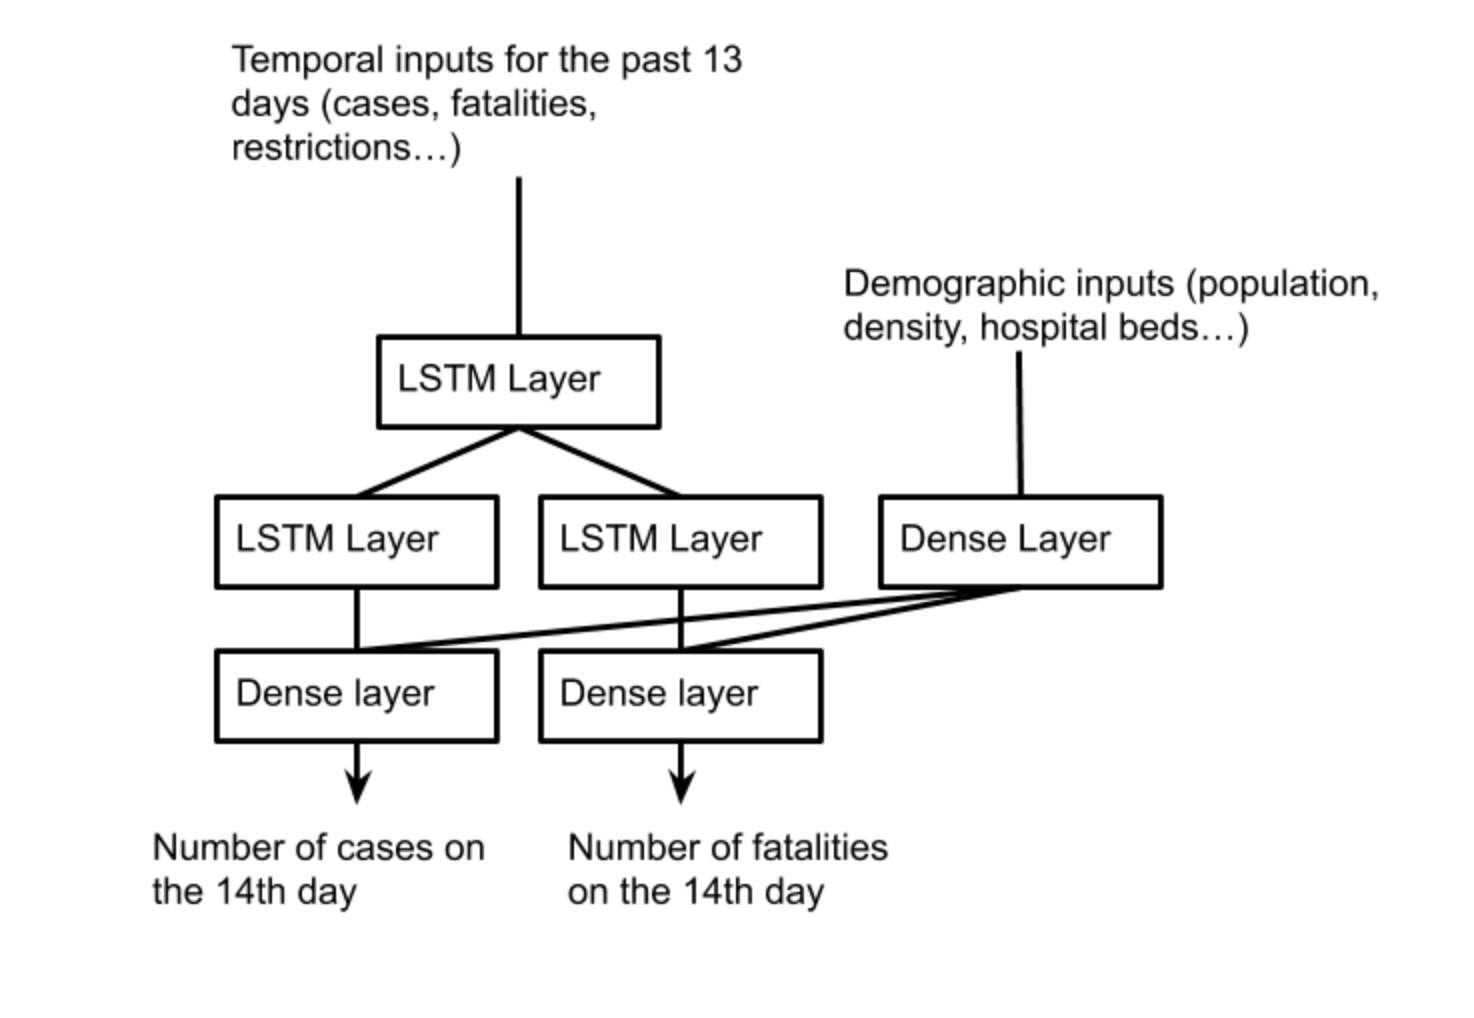

In [101]:
# temporal branch
temporal_input_layer = Input(shape=(sequence_length, 5))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=.2)(temporal_input_layer)

# demographic branch
demographic_input_layer = Input(shape=5)
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(.2)(demographic_dense)

# cases output branch
rnn_cases = layers.LSTM(32)(main_rnn_layer)
merge_cases = layers.Concatenate(axis=1)([rnn_cases, demographic_dropout])
dense_cases = layers.Dense(128)(merge_cases)
dropout_cases = layers.Dropout(.3)(dense_cases)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_cases)

# fatality output branch
rnn_fatalities = layers.LSTM(32)(main_rnn_layer)
merge_fatalities = layers.Concatenate(axis=1)([rnn_fatalities, demographic_dropout])
dense_fatalities = layers.Dense(128)(merge_fatalities)
dropout_fatalities = layers.Dropout(.3)(dense_fatalities)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="fatalities")(dropout_fatalities)

model = Model(inputs=[temporal_input_layer, demographic_input_layer], outputs=[cases, fatalities])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20, 5)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 20, 64)       17920       input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           96          input_4[0][0]                    
______________________________________________________________________________________________

In [107]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], 
              optimizer="adam")

In [108]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_temporal_test,X_demographic_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Epoch 1/250
61/61 [==============================] - 9s 49ms/step - loss: 13.3808 - cases_loss: 11.6472 - fatalities_loss: 1.7336 - val_loss: 7.5677 - val_cases_loss: 6.4502 - val_fatalities_loss: 1.1176
Epoch 2/250
61/61 [==============================] - 2s 31ms/step - loss: 5.3767 - cases_loss: 4.3073 - fatalities_loss: 1.0694 - val_loss: 5.0904 - val_cases_loss: 4.2903 - val_fatalities_loss: 0.8002
Epoch 3/250
61/61 [==============================] - 2s 31ms/step - loss: 3.5022 - cases_loss: 2.8387 - fatalities_loss: 0.6635 - val_loss: 3.9985 - val_cases_loss: 3.3729 - val_fatalities_loss: 0.6255
Epoch 4/250
61/61 [==============================] - 2s 31ms/step - loss: 2.7923 - cases_loss: 2.2722 - fatalities_loss: 0.5201 - val_loss: 3.2245 - val_cases_loss: 2.8105 - val_fatalities_loss: 0.4140
Epoch 5/250
61/61 [==============================] - 2s 30ms/step - loss: 2.3849 - cases_loss: 1.8944 - fatalities_loss: 0.4905 - val_loss: 2.9444 - val_cases_loss: 2.4341 - val_fatalities_l

# **Analysis**

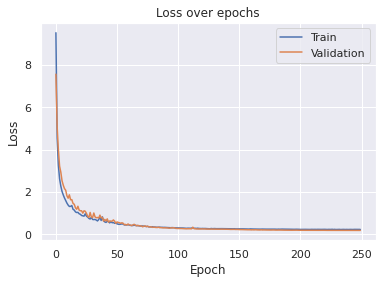

In [109]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

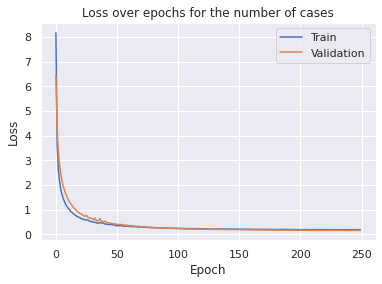

In [110]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

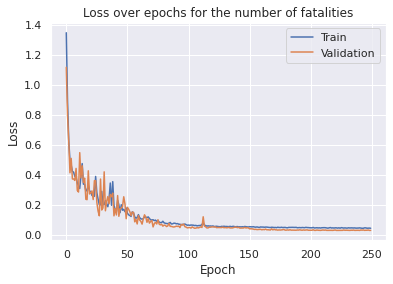

In [111]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# **Prediction**

In [112]:
model.load_weights("best_model.h5")

In [113]:
predictions = model.predict([X_temporal_test,X_demographic_test])


In [114]:
display_limit = 5
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0.]
 [7. 0. 0. 0. 0.]]
Expected cases: 8.0  Prediction: 10.524353 Expected fatalities: 0.0  Prediction: -0.09582299
[[117.   0.   0.   0.   0.]
 [130.   0.   0.   0.   0.]
 [138.   0.   0.   0.   0.]
 [150.   0.   0.   0.   0.]
 [150.   0.   0.   0.   0.]
 [160.   0.   0.   0.   0.]
 [178.   0.   0.   0.   0.]
 [178.   0.   0.   0.   0.]
 [200.   0.   0.   0.   0.]
 [212.   0.   0.   0.   0.]
 [226.   0.   0.   0.   0.]
 [243.   0.   0.   0.   0.]
 [266.   0.   0.   0.   0.]
 [313.   0.   0.   0.   0.]
 [345.   0.   0.   0.   0.]
 [385.   0.   0.   0.   0.]
 [432.   2.   0.   0.   0.]
 [455.   2.   0.   0.   0.]
 [509.   2.   0.   0.   0.]
 [558.   2.   